![simona.png](https://raw.githubusercontent.com/Dreamlone/ITMO_Masters_degree/master/Images/simona.png)

## Основная идея

Клеточный автомат - дискретная модель, которая позволяет моделировать различные сложные системы с помощью перечня простых правил. Данные правила могут задаваться экспертом, или же определяться с помощью вспомогательных алгоритмов. 

В данном ноутбуке приведена идея использования решающих деревьев для инициализации правил, по которым может функционировать основная модель. Алгоритм принимает на вход некоторое количество матриц, на основе которых может строить правила и матрицу-отклик. В простейшем случае реашающее дерево применяется для задачи бинарной классификации.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import scipy
from scipy.signal import convolve2d
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier

Представим, что нам необходимо реализовать модель, которая бы позволяла бы имитировать поведение некоторого пространственного явления. Для простоты опишем рассматриваемое явление как объект бинарной природы, например наличие или отсутствие морского льда на акватории. Лед либо занимает данную акваторию, либо нет. Обозначим присутствие морскго льда значением "1", его отсутствие в данной ячейке - "0".

Пространственное распределение поля льда в момент времени 1 опишем с помощью матрицы A1. Распределение льда в следующий момент времени 2 опишем матрицей A2.

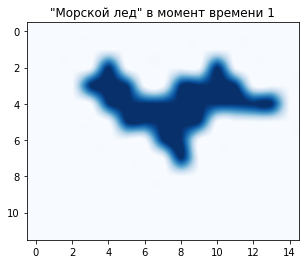

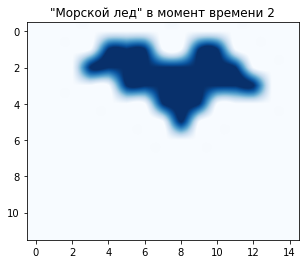

In [46]:
# Пространственное распределение параметра на шаге 1
A1 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
               [0,0,0,1,1,1,0,0,1,1,1,1,0,0,0],
               [0,0,0,0,1,1,1,1,1,1,1,1,1,1,0],
               [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0],
               [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

# Пространственное распределение параметра на шаге номер 2
A2 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,1,1,1,0,0,1,1,0,0,0,0],
               [0,0,0,1,1,1,1,1,1,1,1,1,0,0,0],
               [0,0,0,0,0,1,1,1,1,1,1,1,1,0,0],
               [0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

plt.imshow(A1, cmap = 'Blues', interpolation = 'spline16')
plt.title('"Морской лед" в момент времени 1')
plt.show()

plt.imshow(A2, cmap = 'Blues', interpolation = 'spline16')
plt.title('"Морской лед" в момент времени 2')
plt.show()

Помимо полей с морским льдом у нас будет присутствовать дополнительная информация в виде матриц с распределением температуры воды. Обозначим матрицу в момент времени 1 как B1.

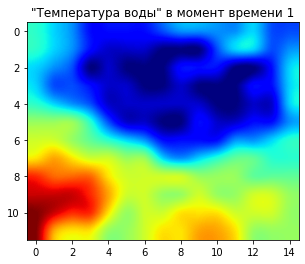

In [47]:
# Поле вспомогательного параметра
B1 = np.array([[ 6, 5, 4, 2, 2, 2, 2, 3, 4, 4, 4, 4, 5, 3, 3],
               [ 6, 5, 4, 2, 1, 1, 1, 0, 0, 0, 3, 5, 5, 3, 4],
               [ 5, 4, 3, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 5],
               [ 5, 3, 3, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 5],
               [ 6, 5, 4, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 5],
               [ 8, 8, 8, 6, 3, 1, 1, 0, 0, 2, 1, 1, 2, 2, 4],
               [ 9, 9, 8, 7, 6, 5, 4, 2, 2, 2, 2, 4, 4, 5, 6],
               [10,11,10, 9, 9, 8, 8, 5, 4, 5, 6, 7, 7, 6, 6], 
               [13,12,12,12,10, 9, 9, 9, 9, 8, 8, 8, 7, 7, 7],
               [14,14,14,13,11, 9, 9, 8, 8, 9, 8, 8, 9, 9, 8],
               [15,14,13,13,10, 8, 9, 9,10,10,10, 9, 9, 9, 8],
               [15,11,10,10, 8, 8, 9,10,10,11,11,10, 8, 8, 8]])

plt.imshow(B1, cmap = 'jet', interpolation = 'spline16')
plt.title('"Температура воды" в момент времени 1')
plt.show()

## Задача - с помощью известных значений параметров в момент времени i попытаться спрогнозировать значение ячейки в момент времени i+1.

Для этого разобъем весь процессинг на 2 блока:

### 1. Определение правил функционирования клеточного автомата 

In [48]:
# Функция составления обучающего датасета для выбранной матрицы
# grid        --- исходная матрица со значениями параметра
# kernel_type --- какое ядро свертки требуется применить для данной сетки ('count', 'average')
# output      --- требуется ли подготовить всего один столбец на основе модифицированного слоя или требуется добавть исходный
# ('source', 'modified', 'both')
def prepare_train(grid, kernel_type = 'count', output = 'modified'):
    
    # Если требуется вернуть только исходный слой, то так и делаем
    if output == 'source':
        return(np.ravel(grid))
    else:
        # Выбор ядра свертки в зависимости от указанного
        if kernel_type == 'count':
            kernel = np.array([[1, 1, 1],
                               [1, 0, 1],
                               [1, 1, 1]])
        elif kernel_type == 'average':
            kernel = np.array([[1/9, 1/9, 1/9],
                               [1/9, 1/9, 1/9],
                               [1/9, 1/9, 1/9]])

        # Применение свертки
        result = convolve2d(grid, kernel, mode="same", boundary="fill")
        result = np.ravel(result)    
        
        if output == 'modified':
            return(result)
        elif output == 'both':
            return(np.ravel(grid), result)    

Формируем датафрейм с предикторами и откликом.

In [49]:
# Теперь подготовим обучающую выборку
# Сколько соседних ячеек (по окрестности Мура) в данный момент являются льдом
neighbs = prepare_train(A1, kernel_type = 'count', output = 'modified')
# Является ли пискель сам льдом в данный момент или нет
state = prepare_train(A1, output = 'source')
# Средняя температура в окрестности данной ячейки
tmp = prepare_train(B1, kernel_type = 'average', output = 'modified')

# Отклик в следующий момент времени
target = prepare_train(A2, output = 'source')

dataframe = pd.DataFrame({'state': state,
                          'tmp': tmp,
                          'neighbs': neighbs,
                          'target': target})

dataframe.head(2)

,state,tmp,neighbs,target
0,0,2.444444,0,0
1,0,3.333333,0,0


Обучаем модель на сформированном датасете.

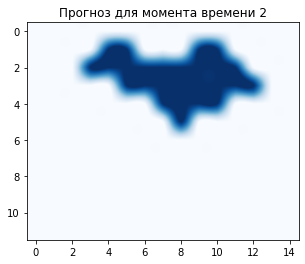

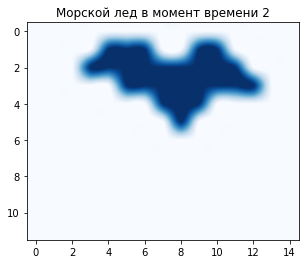

In [80]:
# Решаем задачу бинарной классификации
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 0, max_depth = 10)
clf.fit(dataframe[['state', 'tmp', 'neighbs']], dataframe['target'])

# Посмотрим на качество построенной модели
prediction = clf.predict(dataframe[['state', 'tmp', 'neighbs']])
prediction = prediction.reshape(A2.shape[0], A2.shape[1])

plt.imshow(prediction, cmap = 'Blues', interpolation = 'spline16')
plt.title('Прогноз для момента времени 2')
plt.show()

print('=========================================')
plt.imshow(A2, cmap = 'Blues', interpolation = 'spline16')
plt.title('Морской лед в момент времени 2')
plt.show()

In [105]:
from sklearn.tree import export_text

print(clf.feature_importances_)
tree_rules = export_text(clf, feature_names=['state', 'tmp', 'neighbs'], decimals = 5, max_depth = 100)
print(tree_rules)

[0.0450948  0.71615174 0.23875346]
|--- tmp <= 1.05556
|   |--- neighbs <= 0.50000
|   |   |--- class: 0
|   |--- neighbs >  0.50000
|   |   |--- state <= 0.50000
|   |   |   |--- class: 1
|   |   |--- state >  0.50000
|   |   |   |--- tmp <= 0.83333
|   |   |   |   |--- neighbs <= 4.50000
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- neighbs >  4.50000
|   |   |   |   |   |--- neighbs <= 5.50000
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- neighbs >  5.50000
|   |   |   |   |   |   |--- neighbs <= 6.50000
|   |   |   |   |   |   |   |--- tmp <= 0.61111
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- tmp >  0.61111
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- neighbs >  6.50000
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- tmp >  0.83333
|   |   |   |   |--- class: 1
|--- tmp >  1.05556
|   |--- tmp <= 1.94444
|   |   |--- neighbs <= 0.50000
|   |   |   |--- class: 0
|   |   |--- neighb

In [106]:
def parse_rules(rules):
    rules = rules.split('\n')
    
    # Функция проверки правил
    # Производит определение порядка правила, является ли данный узел листом и корректирует правило
    def check_it(node):
        rank = node.count("|")
        triger = 'class' in node
        splitted_node = node.split('--- ')
        splitted_node = splitted_node[-1]
        
        # Заменяем знак двойного пробела на одинарный
        splitted_node = splitted_node.replace('  ', ' ')
        return(rank, triger, splitted_node)
    
    orders = []
    leafs = []
    new_rules = []
    for rule in rules:
        if rule == '':
            pass
        else:
            # Разбираем правило на состовляющие
            order, is_leaf, splitted_rule = check_it(rule)
            orders.append(order)
            leafs.append(is_leaf)
            new_rules.append(splitted_rule)
        
    orders = np.array(orders)
    new_rules = np.array(new_rules)
    leafs = np.array(leafs)
    
        # Цикл формирования путей в дереве решений
    # До каждого конкретного класса
    dictionary = {}
    paths_to_classes = []
    for i, rank in enumerate(orders):
        if leafs[i] == False:
            # На каждом шаге обновляем словарь, поэтому все пути будут актуальны
            dictionary.update({rank: i})        
        # Если мы дошли до листа в дереве решений
        else:   
            # То заносим путь в массив
            ranks = list(dictionary.keys())
            ranks.sort()
            rules_path = []
            for r in ranks:
                current_rule = new_rules[dictionary.get(r)]
                
                # Также определяем ранг данного правила
                rule_rank = orders[dictionary.get(r)]
                # Если ранг правила меньше, чем в рассматриваемом листе
                if rule_rank >= rank:
                    pass
                else:
                    rules_path.append(current_rule)
            # Добавдяем информацию о назначенной метке
            rules_path.append(new_rules[i])
            paths_to_classes.append(rules_path)
        
    return(paths_to_classes)

paths_to_classes = parse_rules(tree_rules)
for path in paths_to_classes:
    print(path)

['tmp <= 1.05556', 'neighbs <= 0.50000', 'class: 0']
['tmp <= 1.05556', 'neighbs > 0.50000', 'state <= 0.50000', 'class: 1']
['tmp <= 1.05556', 'neighbs > 0.50000', 'state > 0.50000', 'tmp <= 0.83333', 'neighbs <= 4.50000', 'class: 0']
['tmp <= 1.05556', 'neighbs > 0.50000', 'state > 0.50000', 'tmp <= 0.83333', 'neighbs > 4.50000', 'neighbs <= 5.50000', 'class: 1']
['tmp <= 1.05556', 'neighbs > 0.50000', 'state > 0.50000', 'tmp <= 0.83333', 'neighbs > 4.50000', 'neighbs > 5.50000', 'neighbs <= 6.50000', 'tmp <= 0.61111', 'class: 1']
['tmp <= 1.05556', 'neighbs > 0.50000', 'state > 0.50000', 'tmp <= 0.83333', 'neighbs > 4.50000', 'neighbs > 5.50000', 'neighbs <= 6.50000', 'tmp > 0.61111', 'class: 0']
['tmp <= 1.05556', 'neighbs > 0.50000', 'state > 0.50000', 'tmp <= 0.83333', 'neighbs > 4.50000', 'neighbs > 5.50000', 'neighbs > 6.50000', 'class: 1']
['tmp <= 1.05556', 'neighbs > 0.50000', 'state > 0.50000', 'tmp > 0.83333', 'class: 1']
['tmp > 1.05556', 'tmp <= 1.94444', 'neighbs <= 0.5

### 2. Имитация поведения системы на основе выделенных правил

Итак, при помощи решающего дерева мы подготовили наборправил, по которому функионирует модель. Теперь предположим, что у нас есть несколько объектов:

1. Исходная матрица состояний (состоит из 1 и 0), необходимая для инициализации системы
2. Несколько дополнительных матриц (в данном примере - температура), которые необходимы алгоритму

Дополнительные матрицы мы пронумеруем с 1 до n, и занесем в словарь, где выбранная цифра будет являться ключом. 
Подготовим функцию:

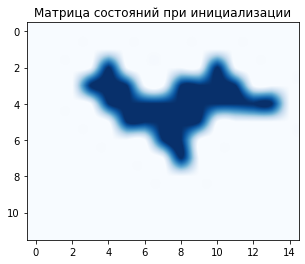

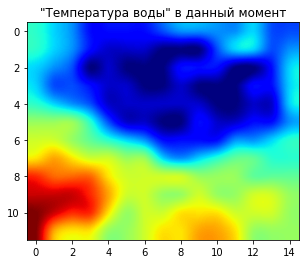

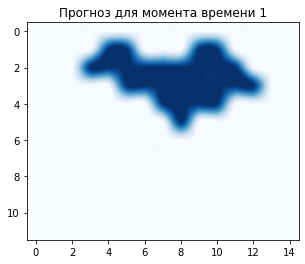

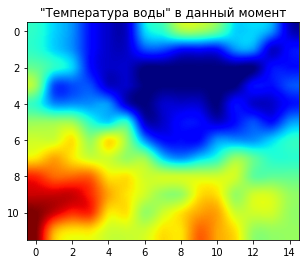

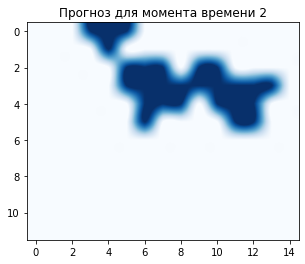

In [104]:
# Функция, позволяющая имитировать поведение системы на основе выделенных правил
### Input:
# paths_to_classes     --- список со всеми "путями" до предсказанных классов
# state_matrix         --- начальная матрица с основным параметром 
# additional_matrices  --- словарь, в котором содержатся матрицы для моделирования 

### Output:
# Производится имитация поведения системы на заданное количество итераций 

def CA_imitation(paths_to_classes, state_matrix, additional_matrices = None):
    
    # Функция проведения симуляции на один шаг вперед 
    ### Input:
    # state (np array)          --- матрица состояний в момент времени step
    # neighbs_matrix (np array) --- матрица соседних значений
    # additional_info           --- словарь с дополнительными матрицами для данного шага
    ### Output:
    # result_matrix (np array)  --- матрица, подготовленная для следующего шага
    def simulation_step(state, neighbs, additional_info, paths_to_classes):
        tmp_matrix = np.copy(additional_info.get('tmp'))
        
        plt.imshow(tmp_matrix, cmap = 'jet', interpolation = 'spline16')
        plt.title('"Температура воды" в данный момент')
        plt.show()
        
        # Операция  свертки для матрицы с температурой
        avg_kernel = np.array([[1/9, 1/9, 1/9],
                               [1/9, 1/9, 1/9],
                               [1/9, 1/9, 1/9]])
        tmp_matrix = convolve2d(tmp_matrix, avg_kernel, mode="same", boundary="fill")
        
        # Словарь для обращения в цикле
        dataset = {'state': state, 'tmp': tmp_matrix, 'neighbs': neighbs}
        # Цикл присваивания меток на пустой матрице
        shape = state.shape
        empty_matrix = np.zeros((shape[0], shape[1]))
        for path in paths_to_classes:
            local_tensor = []
            for rule in path:
                
                rule = rule.split(' ') 
                # Если мы находимся в листе, то завершаем итерацию
                if rule[0] == 'class:':
                    local_tensor = np.array(local_tensor)
                    tensor_shape = local_tensor.shape
                    sum_matrix = np.sum(local_tensor, axis = 0)
                    
                    # Значение суммы в матрице sum_matrix равно высоте многомерной матрицы
                    # Только для нужных ячеек -> присваиваем метку этим ячейкам
                    empty_matrix[sum_matrix == float(tensor_shape[0])] = float(rule[-1])
                else:                    
                    feature_matrix = dataset.get(rule[0])
                    if rule[1] == '<=':
                        local_matrix = np.zeros((shape[0], shape[1]))
                        local_matrix[feature_matrix <= float(rule[-1])] = 1
                        local_tensor.append(local_matrix)
                    elif rule[1] == '<':
                        local_matrix = np.zeros((shape[0], shape[1]))
                        local_matrix[feature_matrix < float(rule[-1])] = 1
                        local_tensor.append(local_matrix)
                    elif rule[1] == '>':
                        local_matrix = np.zeros((shape[0], shape[1]))
                        local_matrix[feature_matrix > float(rule[-1])] = 1
                        local_tensor.append(local_matrix)
                    elif rule[1] == '>=':
                        local_matrix = np.zeros((shape[0], shape[1]))
                        local_matrix[feature_matrix >= float(rule[-1])] = 1
                        local_tensor.append(local_matrix)
                    else:
                        print('Sumbol type error')   
        return(empty_matrix)
    
    # Составляем прозводную информацию о начальном состоянии (считаем количество соседей)
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    neighbs_matrix = convolve2d(state_matrix, kernel, mode="same", boundary="fill")
    
    
    plt.imshow(state_matrix, cmap = 'Blues', interpolation = 'spline16')
    plt.title('Матрица состояний при инициализации')
    plt.show()
    
    # На сколько шагов вперед подготовлены дополнительные матрицы
    steps = list(additional_matrices.keys())    
    for step in steps:
        current_params = additional_matrices.get(step)
        state_matrix = simulation_step(state = state_matrix, neighbs = neighbs_matrix, additional_info = current_params, 
                                       paths_to_classes = paths_to_classes)
        neighbs_matrix = convolve2d(state_matrix, kernel, mode="same", boundary="fill")
        
        name = 'Прогноз для момента времени ' + step
        plt.imshow(state_matrix, cmap = 'Blues', interpolation = 'spline16')
        plt.title(name)F
        plt.show()

# Подготавливаем дополнительные матрицы, B1 уже имеется, сгенерируем марицу B2
B2 = np.array([[ 6, 5, 4, 2, 1, 1, 5, 6, 8, 8, 7, 5, 5, 4, 1],
               [ 6, 5, 4, 2, 1, 1, 3, 3, 2, 2, 2, 4, 4, 1, 2],
               [ 7, 6, 5, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2],
               [ 8, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 3],
               [ 6, 4, 4, 4, 4, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2],
               [ 8, 8, 8, 6, 5, 6, 1, 1, 2, 2, 1, 2, 3, 2, 4],
               [ 9, 9,10, 8,10, 8, 4, 2, 2, 2, 4, 4, 4, 5, 6],
               [10,11,10, 9, 9, 8, 8, 5, 4, 5, 6, 8, 7, 6, 6], 
               [13,12,12,12,10,10, 9, 9, 9, 9, 9, 9, 7, 7, 7],
               [14,14,14,13,11,10, 9, 8, 8,10,10, 8, 9, 9, 8],
               [15,14,13,13,10,10, 8, 9,10,11,11, 9, 9, 9, 8],
               [15,11,10,10, 9, 9, 9,10,10,12,11,10, 8, 8, 8]])
additional_matrices = {'1': {'tmp': B1},
                       '2': {'tmp': B2}}
CA_imitation(paths_to_classes, state_matrix = np.copy(A1), additional_matrices = additional_matrices)    